In [6]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import time
import falconn

from scipy.sparse.linalg import eigs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import johnson_lindenstrauss_min_dim

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Data

In [7]:
def data_generate(n, p, t):
    np.random.seed(t)
    cov = np.identity(p)
    mean1 = np.array([3/np.sqrt(p)]*p)
    mean2 = np.array([-3/np.sqrt(p)]*p)
    x1 = np.random.multivariate_normal(mean1, cov, size=int(n/2))
    x2 = np.random.multivariate_normal(mean2, cov, size=int(n/2))
    data = np.r_[x1, x2]
    
    # randomly permutation index
    #indx = np.random.permutation(n)
    return data

In [8]:
true = np.append(np.array([1]*5000), np.array([0]*5000))

# Spectral Clustering

- Affinity Matrix (KNN)

In [9]:
def Affinity_KNN(data, k, alg='brute'):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm=alg).fit(data)
    return nbrs.kneighbors_graph(data).toarray()

- Normalization

In [15]:
# def Normalization(A):
#     size = A.shape[0]
#     N = np.zeros(shape=(size,size), dtype=float)
    
#     # Degree Vector
#     D = np.sum(A, axis = 1)
    
#     for i in range(size):
#         for j in range(i, size):
#             N[i][j] = A[i][j]/np.sqrt(D[i]*D[j])
#             N[j][i] = N[i][j]
#     return N

In [10]:
def Normalization(A):
    return A/np.sqrt(6)

- Construct Y

In [11]:
def Y_Matrix(N, m):
    size = N.shape[0]
    y = eigs(N,m)[1]
    s = np.linalg.norm(y, axis=1)
    Y = np.array([y[i]/s[i] for i in range(size)])
    return np.real(Y)

- KMeans

In [12]:
def spKmeans(Y,m):
    sp_kmeans = KMeans(n_clusters=m).fit(Y)
    return sp_kmeans.labels_

- Accuracy

In [13]:
def Accuracy(true, test):
    size = test.shape[0]
    acc = np.abs(np.sum(true-test))/size
    if acc > .5:
        return acc
    else:
        return 1-acc

# Exact

In [14]:
def Exact(data, k, m):
    size = data.shape[0]
    start = time.clock()

    A = Affinity_KNN(data, k)
    N = Normalization(A)
    Y = Y_Matrix(N, m)
    test = spKmeans(Y, m)
    end = time.clock()
    
    acc = Accuracy(true, test)
    runtime = end - start
    return acc, runtime

# JL+Exact & JL+KDtree

- epsilon

In [58]:
johnson_lindenstrauss_min_dim(eps=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], n_samples=10000)

array([7894, 2125, 1023,  627,  442,  341,  281,  246,  227])

In [16]:
def epsilon(data):
    dimension = data.shape[1]
    if dimension == 250:
        return 0.9
    elif dimension == 500:
        return 0.6
    elif dimension == 1000:
        return 0.4
    elif dimension == 2000:
        return 0.3

- JL

In [17]:
def JL(data, eps):
    transform = GaussianRandomProjection(eps=eps)
    X = transform.fit_transform(data)
    return X

- JL+Exact

In [18]:
def JL_Exact(data, k, m, eps):
    size = data.shape[0]
    start = time.clock()
    X = JL(data, eps)    
    A = Affinity_KNN(X, k)
    N = Normalization(A)
    Y = Y_Matrix(N, m)
    test = spKmeans(Y, m)
    end = time.clock()
    acc = Accuracy(true, test)
    runtime = end - start
    return acc, runtime

- JL+KDtree

In [19]:
def JL_Kdtree(data, k, m, eps):
    size = data.shape[0]
    start = time.clock()
    X = JL(data, eps)
    A = Affinity_KNN(X, k, alg='kd_tree')
    N = Normalization(A)
    Y = Y_Matrix(N, m)
    test = spKmeans(Y, m)
    end = time.clock()
    acc = Accuracy(true, test)
    runtime = end - start
    return acc, runtime

# LSH

In [20]:
def Affinity_LSH(query_object, x, k):
    A = np.zeros((10000,10000))
    for i in range(10000):
        index = query_object.find_k_nearest_neighbors(x[i],k)
        A[i,index] = 1
    return A

In [21]:
def LSH(data, k, m):
    size = data.shape[0]
    start = time.clock()
    
    params_cp = falconn.LSHConstructionParameters()
    params_cp.dimension = len(data[0])
    params_cp.k = size
    params_cp.l = size
    params_cp.num_rotations = 1
    params_cp.seed = 2018
    params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
    params_cp.num_setup_threads = 0
    params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
    params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
    falconn.compute_number_of_hash_functions(13, params_cp)
    table = falconn.LSHIndex(params_cp)
    table.setup(X_test)
    query_object = table.construct_query_object()
    
    A = lsh_A(query_object, data, k)
    N = Normalization(A)
    Y = Y_Matrix(N, m)
    test = spKmeans(Y, m)
    end = time.clock()
    acc = Accuracy(true, test)
    runtime = end - start
    
    return acc, runtime

# Figure

In [ ]:
def figure():
    acc1 = np.zeros(4)
    acc2 = np.zeros(4)
    acc3 = np.zeros(4)
    acc4 = np.zeros(4)
    runtime1 = np.zeros(4)
    runtime2 = np.zeros(4)
    runtime3 = np.zeros(4)
    runtime4 = np.zeros(4)
    p = [250, 500, 1000, 2000]
    
    for i in range(4):
        data = data_generate(5000, p[i], 1)
        eps = epsilon(data)
        acc1[i], runtime1[i] = Exact(data, 5, 2)
        acc2[i], runtime2[i] = JL_Exact(data, 5, 2)
        acc3[i], runtime3[i] = JL_Kdtree(data, 5, 2)
        acc4[i], runtime4[i] = LSH(data, 5, 2)
            
    plt.plot(p, acc1, label = 'Exact')
    plt.plot(p, acc2, label = 'JL_Exact')
    plt.plot(p, acc3, label = 'JL_Kdtree')
    plt.plot(p, acc4, label = 'LSH')
    plt.title('Accurace vs p')
    plt.xlabel('p')
    plt.ylabel('Accurace')
    plt.legend()
    plt.savefig('Accurace.pdf', bbox_inches='tight')
    
    plt.plot(p, runtime1, label = 'Exact')
    plt.plot(p, runtime2, label = 'JL_Exact')
    plt.plot(p, runtime3, label = 'JL_Kdtree')
    plt.plot(p, runtime4, label = 'LSH')
    plt.title('Runtime vs p')
    plt.xlabel('p')
    plt.ylabel('Runtime/s')
    plt.legend()
    plt.savefig('Runtime.pdf', bbox_inches='tight')

In [22]:
pvalue = [250, 500, 1000, 2000]
acc1 = [0.98267, 0.95149, 0.8432, 0.63729]
acc2 = [0.93, 0.84, 0.6, 0.53]
acc3 = [0.93, 0.86, 0.61, 0.52]
acc4 = [0.9822, 0.9577, 0.8658, 0.6765]

runtime1 = [268.767, 520, 1500, 3000]
runtime2 = [275, 500, 1200, 2300]
runtime3 = [270, 510, 1300, 2200]
runtime4 = [308.7267, 547.2065, 1159.8567, 2248.5725]

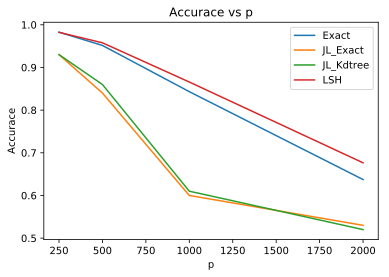

In [23]:
plt.plot(pvalue, acc1, label = 'Exact')
plt.plot(pvalue, acc2, label = 'JL_Exact')
plt.plot(pvalue, acc3, label = 'JL_Kdtree')
plt.plot(pvalue, acc4, label = 'LSH')
plt.title('Accurace vs p')
plt.xlabel('p')
plt.ylabel('Accurace')
plt.legend()
plt.savefig('Accurace.pdf', bbox_inches='tight')
plt.show()

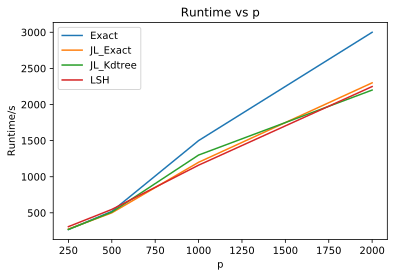

In [24]:
plt.plot(pvalue, runtime1, label = 'Exact')
plt.plot(pvalue, runtime2, label = 'JL_Exact')
plt.plot(pvalue, runtime3, label = 'JL_Kdtree')
plt.plot(pvalue, runtime4, label = 'LSH')
plt.title('Runtime vs p')
plt.xlabel('p')
plt.ylabel('Runtime/s')
plt.legend()
plt.savefig('Runtime.pdf', bbox_inches='tight')
plt.show()

In [25]:
eps = [0.4, 0.6, 0.7, 0.8, 0.9]
a = [0.526, 0.521, 0.519, 0.52, 0.515]
t = [2200, 1900, 1300, 1000, 900]

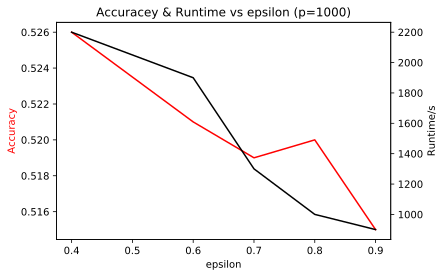

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(eps, a, color='r', label = 'Accuracy')
ax1.set_ylabel('Accuracy', color='r')
ax1.set_xlabel('epsilon')

ax2 = ax1.twinx()
ax2.plot(eps, t, color='black', label = 'Runtime')
ax2.set_ylabel('Runtime/s', color='black')

plt.title('Accuracey & Runtime vs epsilon (p=1000)')

plt.savefig('eps.pdf', bbox_inches='tight')
plt.show()